In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt
import gymnasium as gym

from FFNN import FFNN
from blackjackenv_extended import BlackjackEnv

from random_agent import RandomAgent
from basic_strategy_agent import BasicStrategyAgent
from backprop_agent import BackpropAgent
from FFNN_agent import FFNNAgent
from DQFFNN_BJ_agent import DQFFNNAgentBJ
from DQFFNN_agent import DQFFNNAgent

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("using gpu: ", torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print("using cpu")

np.random.seed(43)

c:\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


using cpu


## Blackjack

In [ ]:
env = BlackjackEnv(natural=True)

episodes = 10000
collect_data = False

In [2]:
KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE', 3: 'SPLIT'}


def play_game(env, episodes, agent, collect_data=False, print_rewards=True):
    rewards = []

    for episode in tqdm(range(episodes)):
        observation, info = env.reset()
        done = False
        
        # print(f"Episode: {episode+1}/{episodes}")
        # print("-"*40)
        # print("hand 1", env.player)
        # print("hand 2", env.player2)
        # print("Start Observation: ", observation)
        
        
        while not done:
            
            action = agent.get_action(observation)
            #print("Action: ", KEY[action])

            # save data for training
            if collect_data:
                agent.collect_data(observation, action)
            
            next_observation, reward, terminated, truncated, info = env.step(action) 
            agent.learn(observation, action, reward, next_observation, terminated or truncated)
            observation = next_observation
            
            # print("hand 1", env.player)
            # print("hand 2", env.player2)
            # print("Observation: ", observation, "Reward: ", reward)
            

            if terminated or truncated:
                # print(f"Dealer hand: ", env.dealer)
                rewards.append(reward)
                observation = env.reset()
                done = True
        
        agent.decay_epsilon()    

    if collect_data:
        agent.save_data()
    
    average_reward = sum(rewards)/episodes
    variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

    if print_rewards:
        #print("Rewards: ", rewards)
        print("Average Reward: ", average_reward)
        print("Variance: ", variance)
    
    return rewards

In [1]:
def plot_reward(data, title, filename, labels, plot_variance=False):
    data = np.array(data)
    np.savetxt(f'../data/{filename}.csv', data.reshape(data.shape[0], -1), delimiter=',')

    rolling_length = 1000
    
    _, ax = plt.subplots()
    
    if plot_variance:
        mean = data.mean(axis=0)
        variance = data.var(axis=0)
        plt.plot(mean, label='Mean', color='blue')
        plt.fill_between(mean - variance, mean + variance, alpha=0.2, label='Variance')
    else:
        rolling_mean = np.zeros((len(data), len(data[0]) - (rolling_length - 1))) 
        for i in range(len(data)):
            rolling_mean[i] = (np.convolve(np.array(data[i]).flatten(), np.ones(rolling_length), mode="valid")
                / rolling_length)
            ax.plot(rolling_mean[i], label=labels[i])

    plt.ylabel("Reward")
    plt.xlabel("Episodes")
    plt.title(title)
    plt.legend()
    plt.savefig(f"../data/{filename}.png", dpi='figure', format=None)
    plt.show()

### Random & Basic Agents

In [ ]:
agent = RandomAgent(env, filename="random_agent")
rewards_random = play_game(env, episodes, agent, collect_data)


agent = BasicStrategyAgent(env, filename="basic_strategy_agent")
rewards_basic_strategy = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_random, rewards_basic_strategy], "Random vs Basic Strategy Agent", "random_basic_strategy", ["Random Agent", "Basic Strategy Agent"])

## Data Generation

### Simulated Data

In [2]:
def read_data(file):
    return pd.read_csv(file, delimiter=',')

In [3]:
def split_data(data, test_split=True):
    x = data[:, :5]
    y = data[:, 5]
    if test_split:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=37)
    else:
        x_train, x_test, y_train, y_test = x, x, y, y
    return x_train, x_test, y_train, y_test

def transform(data):
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [4]:
def preprocess(filename, test_split=True):
    df_raw = read_data(filename)
    print(df_raw.head())
    d_raw = df_raw.to_numpy() # data to binary?
    x, x_test, y, y_test = split_data(d_raw, test_split)
    x, x_test = transform(x), transform(x_test)
    
    return x, x_test, y, y_test

In [5]:
datafile = '../data/basic_strategy_agent.csv'
x_train, x_test, y_train, y_test = preprocess(datafile)

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0           8           10           0                    1              0   
1          18           10           0                    0              0   
2          16           10           0                    1              0   
3          11            9           0                    1              0   
4          21           10           1                    1              0   

   Action  
0       1  
1       0  
2       1  
3       2  
4       0  


In [6]:
def one_hot_encode(y, n):
    return torch.eye(n)[y]

def combine_input_and_label(x, y, n):
    y_one_hot = one_hot_encode(y, n)
    return torch.concat((x, y_one_hot), 1)

def generate_neg_labels(y, n):
    y_ = y.copy()
    for i in range(len(y)):
        negative_labels = [j for j in range(n) if j != y[i]]
        y_[i] = np.random.choice(negative_labels)

    return y_

In [7]:
x_pos = combine_input_and_label(x_train, y_train, 4)

y_neg = generate_neg_labels(y_train, 4)
x_neg = combine_input_and_label(x_train, y_neg, 4)

y_train_OH = one_hot_encode(y_train, 4)
y_test_OH = one_hot_encode(y_test, 4)


print(f"x_pos[0]: {x_pos[0]}")
print(f"x_neg[0]: {x_neg[0]}")
print(f"Train size: {len(x_train)}")
print(f"Test size: {len(x_test)}")

x_pos[0]: tensor([16., 10.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])
x_neg[0]: tensor([16., 10.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])
Train size: 113
Test size: 29


### Balanced Data

In [21]:
env = BlackjackEnv(natural=True)
basic_strategy_agent = BasicStrategyAgent(env, filename='../data/blackjack_combinations')

def create_combinations():
    for player_hand in range(4, 22):
        for dealer_hand in range(2, 12):
            for usable_ace in range(2):
                for can_double_down in range(2):
                    for can_split in range(2):
                        observation = (player_hand, dealer_hand, usable_ace, can_double_down, can_split)
                        if (dealer_hand == 11 and usable_ace) == 1:
                            # impossible combination
                        
                            continue
                        action = basic_strategy_agent.get_action(observation)
                        basic_strategy_agent.collect_data(observation, action)
    
    basic_strategy_agent.save_data()
                        
            
def get_combinations_for_action(action):
    samples = []
    with open('../data/blackjack_combinations.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            if int(row[-1]) == action:
                samples.append(row)
    return samples

def sample_balanced_data(n_samples):
    data = []
    combinations = np.empty(4, dtype=object)
    
    for action in range(4):
        combinations[action] = get_combinations_for_action(action)
        
        for i in range(n_samples):
            sample_idx = np.random.choice(len(combinations[action]))
            data.append(combinations[action][sample_idx])

    with open('../data/balanced_data.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        
        writer.writerow(["Player sum", "Dealer card", "Usable ace", "Double down allowed", "Split allowed", "Action"])
        writer.writerows(data)

In [9]:
create_combinations()
samples_per_action = 30_000
sample_balanced_data(samples_per_action)

In [32]:
datafile = '../data/blackjack_combinations.csv'
x_train_bal, x_test_bal, y_train_bal, y_test_bal = preprocess(datafile, test_split=False)

x_pos_bal = combine_input_and_label(x_train_bal, y_train_bal, 4)

y_neg_bal = generate_neg_labels(y_train_bal, 4)
x_neg_bal = combine_input_and_label(x_train_bal, y_neg_bal, 4)

y_train_OH_bal = one_hot_encode(y_train_bal, 4)
y_test_OH_bal = one_hot_encode(y_test_bal, 4)


print(f"x_pos[0]: {x_pos_bal[0]}")
print(f"x_neg[0]: {x_neg_bal[0]}")
print(f"Train size: {len(x_train_bal)}")
print(f"Test size: {len(x_test_bal)}")

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0           4            2           0                    0              0   
1           4            2           0                    0              1   
2           4            2           0                    1              0   
3           4            2           0                    1              1   
4           4            2           1                    0              0   

   Action  
0       1  
1       3  
2       1  
3       3  
4       1  
x_pos[0]: tensor([4., 2., 0., 0., 0., 0., 1., 0., 0.])
x_neg[0]: tensor([4., 2., 0., 0., 0., 0., 0., 0., 1.])
Train size: 1368
Test size: 1368


## Forward-Forward

In [8]:
def print_accuracy(model_predictions, y):
    predictions = np.array(torch.Tensor.cpu(model_predictions)).flatten()
    accuracy =  model_predictions.eq(torch.from_numpy(y).to(device)).float().mean().item()
    
    print(y)
    print(predictions)
    print(f'Accuracy: {accuracy}')

    ConfusionMatrixDisplay.from_predictions(y, predictions)
    
def plot_losses(data, title, filename):
    
    np.savetxt(f'../data/{filename}_losses.csv', data, delimiter=',')


    plt.plot(np.array(data))

    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.title(title)
    plt.savefig(f"../data/{filename}_losses.png", dpi='figure', format=None)
    plt.show()

### Balanced Data FFNN

In [ ]:
# Hyperparameters
layers = [9, 2000, 2000, 2000, 2000]
threshold = 6 # 0.5?
learning_rate = 0.001
epochs = 120
batch_size = 64
lr_decay = False

model = FFNN(
    device=device,
    layers=layers,
    threshold=threshold,
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    ).to(device)


3000


In [ ]:
last_layer_losses = model.train(x_pos_bal, x_neg_bal)
model.save_model('../models/model_balanced.pth')

Accuracy: 0.7909356951713562


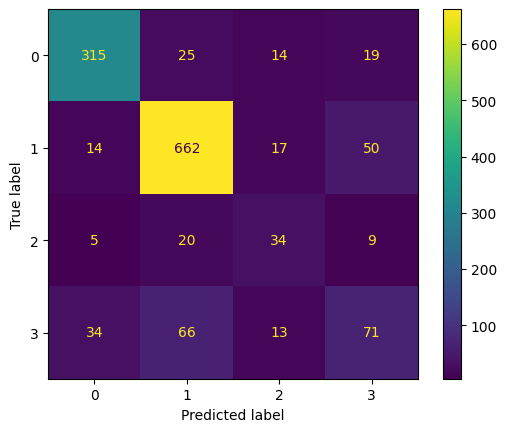

In [ ]:
plot_losses(last_layer_losses, "Training Loss Last Layer Balanced Model", "model_balanced")
print_accuracy(model.predict_accumulated_goodness(x_test_bal), y_test_bal)

### FFNN

In [10]:
def cross_validation(x_pos, x_neg,architectures, thresholds, learning_rates, n_epochs, n_folds, batch_sizes, lr_decays):
    
    size_subset = len(x_pos) // n_folds
    validation_risks = []
    
    for architecture in tqdm(architectures):
        for threshold in thresholds:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for lr_decay in lr_decays:
                        print(f"Current Model:{architecture}, thr={threshold}, lr={lr}, batch_size={batch_size}, lr_decay={lr_decay}")
                        print("-"*40)
                        val_risks_model = []
                        
                        for fold in range(n_folds):
                            print(f"Fold {fold}")
                            print("-"*40)
                            
                            # Split data into training and validation
                            start_idx = fold * size_subset
                            end_idx = (fold + 1) * size_subset
                            x_pos_train = torch.cat((x_pos[:start_idx], x_pos[end_idx:]))
                            x_neg_train = torch.cat((x_neg[:start_idx], x_neg[end_idx:]))
                            x_val = x_train[start_idx:end_idx]
                            y_val = y_train[start_idx:end_idx]
                            
                            # Initialize current model
                            model = FFNN(
                                device=device,
                                layers=architecture,
                                bias=True,
                                threshold=threshold,
                                learning_rate=lr,
                                epochs=n_epochs,
                                batch_size=batch_size,
                                lr_decay=lr_decay
                            ).to(device)
                            
                            # Train model
                            model.train(x_pos_train, x_neg_train)
                            
                            # Compute validation risk
                            predictions = model.predict_accumulated_goodness(x_val) # juiste risk?
                            val_risk = 1 - predictions.eq(torch.from_numpy(y_val).to(device)).float().mean().item()
                            val_risks_model.append(val_risk)
                            
                            print(f"\n validation risk: {val_risk}")
                            
                        avg_val_risk = np.mean(val_risks_model)
                        validation_risks.append((architecture, threshold, lr, batch_size, lr_decay, avg_val_risk ))
                        #model.save_model(f'../models/model_{architecture}_{threshold}_{lr}_{avg_val_risk}.pth')
                        
                        with open('../data/cxv_results.csv', 'a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow([architecture, threshold, lr, batch_size, lr_decay, avg_val_risk])
                            
                        print("-"*40)
                        print(f"validation risks for model {architecture}, thr={threshold}, lr={lr}: {val_risks_model}")
                        print(f"average validation risk: {avg_val_risk}\n")
    
    print("total validation risks:" , validation_risks)  
    min_risk_model = min(validation_risks, key=lambda x: x[-1])
    print(f"Best model: {min_risk_model}")   
    return min_risk_model               

In [ ]:
# Hyperparameters
architectures = [
    [9,30,30],
    [9,100,100],
    [9,500,500],
    [9,100,100,100],
    [9,200,200,200],
    [9,1000,1000,1000],
    [9,2000,2000,2000,2000],
]
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 3, 5, 7]
learning_rates = [0.0001,0.001,0.01,0.03]
n_epochs = 1000
n_folds = 10
batch_sizes = [64, 500, len(x_train)]
lr_decays = [0, 1]

best_model = cross_validation(
    x_pos, 
    x_neg, 
    architectures,
    thresholds,
    learning_rates,
    n_epochs,
    n_folds,
    batch_sizes,
    lr_decays
)

In [22]:
# Best model hyperparameters
architecture_best = best_model[0]
threshold_best = best_model[1]
learning_rate_best = best_model[2]
epochs = 1000
batch_size = best_model[3]
lr_decay = best_model[4]

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay
).to(device)

Best model: [9, 100, 100, 100], thr=0.5, lr=0.03


In [ ]:
last_layer_losses = model.train(x_pos, x_neg)
model.save_model('../models/best_model.pth')

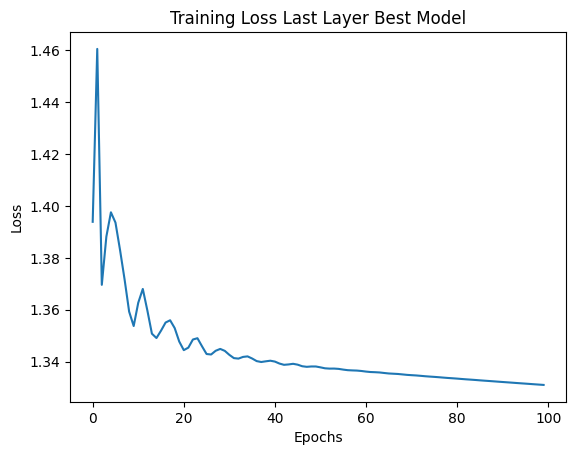

[0 2 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 2 0 0 1 0 1 0 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 0 1 0 1 0 0 0 0 3 0 3 0 0]
Accuracy: 0.6206896305084229


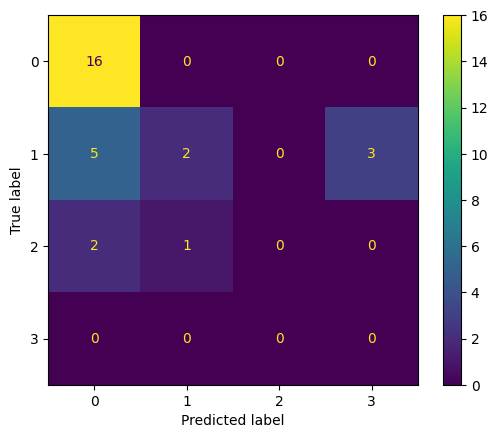

In [24]:
plot_losses(last_layer_losses, "Training Loss Last Layer Best Model", "best_model")
print_accuracy(model.predict_accumulated_goodness(x_test), y_test)


### FFNN with Softmax Classifier

In [11]:
# Best model hyperparameters
architecture_best = [9,2000,2000,2000,2000]
threshold_best = 0.5
learning_rate_best = 0.001
epochs = 120
batch_size = len(x_train)
lr_decay = False

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    classifier=True
).to(device)

model.train(x_pos, x_neg)
model.train_classifier(x_pos, y_train_OH, epochs)
model.save_model('../models/softmax_model.pth')
torch.save(model.classifier.state_dict(), '../models/softmax_model_classifier.pth')

Best model: [9, 2000, 2000, 2000, 2000], thr=0.5, lr=0.001


100%|██████████| 300/300 [00:23<00:00, 12.90it/s]



Training Softmax
----------------------------------------


100%|██████████| 300/300 [00:00<00:00, 551.35it/s]


Last epoch loss: 0.3362576365470886


[1 0 0 0 0 0 0 2 0 2 0 1 0 0 0 0 2 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0
 0 0 3 0 0 1 2 0 0 0 1 0 0 0 3 1 0 0 0 0 1 1 2 0 1 1 3 1 0 0 0 3 2 1 2 0 0
 1 0 0 0 1 1 0 1 1 0 1 2 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1
 1 0]
[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 2 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 2 0 1 1 3 1 0 0 0 0 2 1 1 0 0
 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 3 0 1 1 1 0 1 1 1 1 0 0 0 1 0 2
 1 0]
Accuracy: 0.8761062026023865


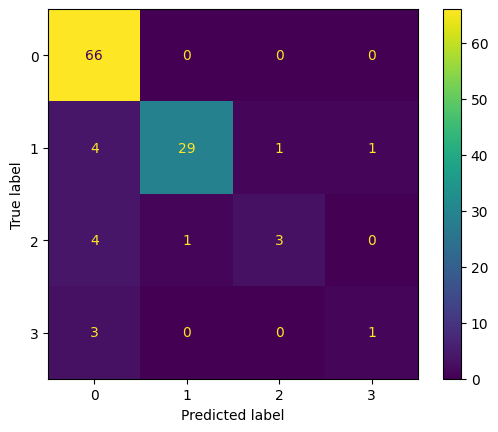

In [12]:
print_accuracy(model.predict_classifier(x_train),y_train)

## Backpropagation

In [26]:
def train(model, x, y, epochs, loss_function, optimizer, batch_size):
    
    model.train()
    num_batches = len(x) // batch_size
    
    for epoch in range(epochs):
        losses = []
        for batch in tqdm(range(num_batches)):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        print(f"epoch: {epoch + 1}/{epochs} avg. loss: {sum(losses)/len(losses)}")

In [27]:
def test(model, x_test, y_test, loss_function):
    
    model.eval()
    
    with torch.no_grad():
        predictions = model(x_test)
        test_loss = loss_function(predictions, y_test).item()
        
    print(f"avg. test loss: {test_loss}")   
    
def predict_actions(model, x):
    model.eval()
    
    with torch.no_grad():
        predictions = model(x)
        return predictions.argmax(1)

In [28]:
from backpropNN import BackpropNN

input_size = 5
output_size = 4

# hyperparameters
hidden_size = 30
activation_function = nn.ReLU()

# fully connected neural network with 4 hidden layers
backprop_model = BackpropNN(input_size, output_size, hidden_size, activation_function)

In [32]:
# hyperparameters
epochs = 100
batch_size = 64
learning_rate = 0.001

optimizer = torch.optim.Adam(backprop_model.parameters(), lr=learning_rate);
loss_fn = nn.CrossEntropyLoss()

train(backprop_model, x_train, y_train_OH, epochs, loss_fn, optimizer, batch_size)
torch.save(backprop_model.state_dict(), '../models/backprop_model.pth')

100%|██████████| 26/26 [00:00<00:00, 519.77it/s]


epoch: 1/10 avg. loss: 1.3648410806289086


100%|██████████| 26/26 [00:00<00:00, 806.64it/s]


epoch: 2/10 avg. loss: 1.268617909688216


100%|██████████| 26/26 [00:00<00:00, 812.50it/s]


epoch: 3/10 avg. loss: 1.1571954580453725


100%|██████████| 26/26 [00:00<00:00, 649.74it/s]


epoch: 4/10 avg. loss: 1.072003308397073


100%|██████████| 26/26 [00:00<00:00, 788.24it/s]


epoch: 5/10 avg. loss: 1.028952459876354


100%|██████████| 26/26 [00:00<00:00, 896.65it/s]


epoch: 6/10 avg. loss: 1.009978154530892


100%|██████████| 26/26 [00:00<00:00, 758.64it/s]


epoch: 7/10 avg. loss: 0.9906617953227117


100%|██████████| 26/26 [00:00<00:00, 684.24it/s]


epoch: 8/10 avg. loss: 0.970029585636579


100%|██████████| 26/26 [00:00<00:00, 837.89it/s]


epoch: 9/10 avg. loss: 0.9461542574258951


100%|██████████| 26/26 [00:00<00:00, 896.49it/s]


epoch: 10/10 avg. loss: 0.9243824871686789


In [152]:
test(backprop_model, x_test, y_test_OH, loss_fn)

avg. test loss: 0.9507748484611511


In [153]:
# print(torch.from_numpy(y_test))
# print(predict_action(backprop_model, x_test))
accuracy = predict_actions(backprop_model, x_test).eq(torch.from_numpy(y_test)).float().mean().item() # heet dit accuracy?
print(accuracy)

tensor([0, 1, 1,  ..., 1, 0, 0])
tensor([0, 0, 0,  ..., 0, 0, 0])
0.5006591975688934


## FFNN Blackjack

### FFNN & Backpropagation

In [ ]:
# FFNN hyperparameters
model_path = '../models/best_model.pth'
layers = best_model[0]
threshold = best_model[1]
lr = best_model[2]

agent = FFNNAgent(
    env,
    model_path=model_path,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    filename="ffnn_agent"
)

rewards_FFNN = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_FFNN], "FFNN Agent", "ffnn_agent", ["FFNN Agent"])

100%|██████████| 10000/10000 [00:06<00:00, 1530.05it/s]


Average Reward:  -0.0039
Variance:  1.2864134313432152


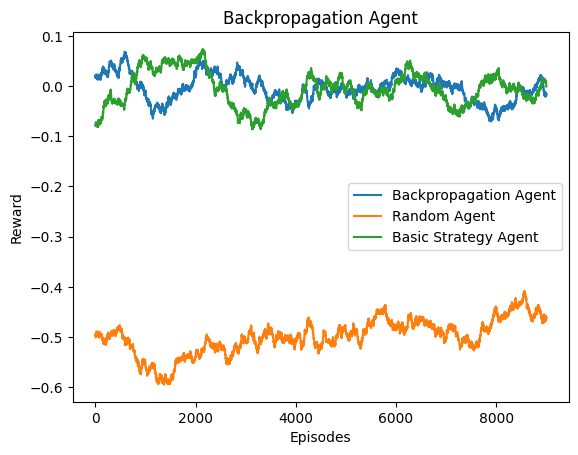

In [ ]:
# Backprop hyperparameters
input_size = 5
output_size = 4
hidden_size = 30
activation_fn = nn.ReLU()

agent = BackpropAgent(
    env, 
    model=torch.load('../models/backprop_model.pth'),
    input_size=input_size, 
    output_size=output_size, 
    hidden_size=hidden_size, 
    activation_fn=activation_fn,
    filename="backprop_agent"
)

rewards_BP = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_BP, rewards_random, rewards_basic_strategy], "Backpropagation Agent", "backprop_random_basic_agent", ["Backpropagation Agent", "Random Agent", "Basic Strategy Agent"])

### DQFFNN

In [ ]:
# DQFFNN hyperparameters
layers = [9,200,200,200]
threshold = 6
lr = 0.01

episodes = 10001
epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.99
batch_size = 5
update_td_target = 50
buffer_size = 100000

agent = DQFFNNAgentBJ(
    env,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor,
    batch_size=batch_size,
    update_td_target=update_td_target,
    buffer_size=buffer_size,
    filename="dqffnn_agent"
)

#agent.model.save_model(path='../models/DQFFNN_model.pth')
rewards_DQFFNN = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_DQFFNN], "DQFFNN Agent", f"DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}", ["DQFFNN Agent"])

In [ ]:
print_accuracy(agent.model.predict_accumulated_goodness(x_test), y_test)

#### Cartpole

In [ ]:
layers = [6,1000,1000,1000,1000]
threshold = 0.5
lr = 0.001

episodes = 80000
epsilon = 1.0
epsilon_decay = epsilon / (episodes)
discount_factor = 0.99
batch_size = 5
update_td_target = 50
buffer_size = 100000

env = gym.make("CartPole-v1")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

agent = DQFFNNAgent(
    env,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor,
    batch_size=batch_size,
    update_td_target=update_td_target,
    buffer_size=buffer_size
)

agent.model.save_model(path='../models/Cartpole_DQFFNN_model.pth')
play_game(env, episodes, agent, False, False)
rewards = np.array(env.return_queue).flatten()
average_reward = sum(rewards)/episodes
variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

#print("Rewards: ", rewards)
print("Average Reward: ", average_reward)
print("Variance: ", variance)
plot_reward(rewards, "Cartpole", f"Cartpole_DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}")

#### Mountain Car

In [ ]:
layers = [5,1000,1000,1000,1000]
threshold = 0.4
lr = 0.0001

episodes = 10
epsilon = 1.0
epsilon_decay = epsilon / (episodes)
discount_factor = 0.99
batch_size = 5
update_td_target = 100
buffer_size = 100000

env = gym.make("MountainCar-v0", render_mode="human")
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)

agent = DQFFNNAgent(
    env,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    discount_factor=discount_factor,
    batch_size=batch_size,
    update_td_target=update_td_target,
    buffer_size=buffer_size
)

agent.model.save_model(path='../models/MountainCar_DQFFNN_model.pth')
play_game(env, episodes, agent, False, False)
rewards = np.array(env.return_queue).flatten()
average_reward = sum(rewards)/episodes
variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

#print("Rewards: ", rewards)
print("Average Reward: ", average_reward)
print("Variance: ", variance)
plot_reward(rewards, "MountainCar", f"MountainCar_DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}")